In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import norm,uniform
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.optimize import minimize
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
    
sbn.set_style('white')
sbn.set_context('talk')

In this workbook, I will briefly go over the theory of MCMC.  We'll cover questions like why does MCMC work (why does it allow us to draw from the posterior)? and what conditions are necessary to get this result.

## Asymptotics

A decent starting point is to go back to our simple example using conjugate priors and analytical Bayes.  Our data is distributed normal with mean $\mu$ (unknown) and standard deviation equal to $\sigma$ (known).  We have priors describing our beliefs about the distribution of $\mu$: distributed normal with mean $\mu_0$  and standard deviation $\sigma^2_0$. In this setting, our posterior can be solved for analytically as: 

$$
N \left (\frac{\sigma_0^2}{\frac{\sigma^2}{n} + \sigma^2_0}\frac{\sum y_i}{n} + \frac{\frac{\sigma^2}{n}}{\frac{\sigma^2}{n} + \sigma^2_0} \mu_0,\left ( {\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}} \right )^{-1} \right ) 
$$

How might we expect the posterior to behave as sample size get increasingly large?  First examine the mean of the analytical posterior: 

$$
\lim_{n\to \infty} \frac{\sigma_0^2}{\frac{\sigma^2}{n} + \sigma^2_0}\frac{\sum y_i}{n} + \frac{\frac{\sigma^2}{n}}{\frac{\sigma^2}{n} + \sigma^2_0} \mu_0 \to \frac{\sum y_i}{n}
$$
which means that the mean of the analytical posterior will converge on the Maximum Likelihood Estimate of the mean: the data completely dominates the prior.

What about the variance?  Doing a similar excercise shows that

$$
\lim_{n\to \infty} \left ( {\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}} \right )^{-1} = \lim_{n\to \infty} \left ( \frac{\sigma^2_0 \sigma^2}{(\sigma^2 + n \sigma^2_0)}\right ) \to 0
$$

So, the asymptotic properties of our Bayesian estimator, exactly parallels the frequentist worldview: our posterior collapses to the Maximum Likelihood Mean with zero variance for super huge sample sizes.  

We can also see this using numerical methods and revisit our example from 2 worksheets ago:

1. Mean of data is unknown, variance is known ($\sigma=3$)
2. Priors $\mu_0 = 8$, $\sigma_0 = 2$


In [2]:
# plot the MLE mean, and MAP estimate at different sample 
# sizes of data given below
sample_size = [1,10,10**2,10**3,10**6]

sigma = 3
mu_0 = 8
sigma_0 = 2

In [3]:
def log_posterior_numerical(mu,data,sigma,mu_0,sigma_0):
    log_prior = norm(mu_0,sigma_0).logpdf(mu)
    log_like = norm(mu,sigma).logpdf(data).sum()
    return -1*(log_prior + log_like)

In [4]:
# for each sample size, generate a dataset and calculate
# 1. MAP
# 2. MLE (just the mean of the data)
# and store results

results = np.zeros((len(sample_size),4))

count=0
for i in sample_size:
    data = norm(10,3).rvs(i)
    # for this dataset, solve for map
    res = minimize(log_posterior_numerical,np.mean(data), 
               args=(data,sigma,mu_0,sigma_0),options={'disp': False},
               method='BFGS')
    
    results[count,:] = [i,mu_0,res.x,np.mean(data)]
    count+=1

In [5]:
# convert to a pandas dataframe
results=pd.DataFrame(results,columns=['Sample Size','Prior','MAP','MLE'])

In [6]:
results.head()

Sample Size  Prior        MAP        MLE
0          1.0    8.0   9.019413  11.313092
1         10.0    8.0   8.071362   8.087419
2        100.0    8.0   9.999679  10.044672
3       1000.0    8.0  10.075359  10.080028
4    1000000.0    8.0   9.999080   9.999085

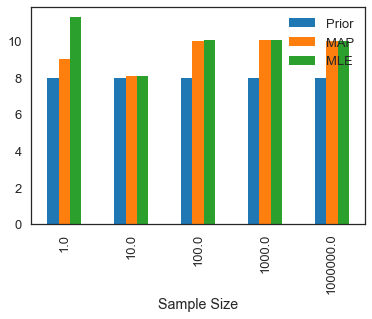

In [7]:
results.set_index('Sample Size').plot(kind='bar')
plt.show()

# Properties of MCMC

This section draws **very heavily** from Patrick Lam's excellent course notes [here](http://patricklam.org/teaching/mcmc_print.pdf)

The last notebook asserted that by using the Metropolis Hasting algorithm to construct a Monte-Carlo Markov Chain, is akin to drawing randomly from the posterior distribution of the parameters.  Why is this the case and what conditions do we need for it to hold true?  

There are proofs showing that with appropriate choices of the proposal distribution $q(\theta^P_{t+1},\theta_t)$, the sequence of values we construct using MH is a markov chain approximately equal to taking random draws from the posterior: $p(\theta|\mathbf{y,x}$) [see page 124 "Contemporary Bayesian Econometrics and Statistics", John Geweke].

### Markov Chains

> is a **stochastic process** in which future states are independent of past states given the present state

* **stochastic process**: a consecutive set of random quantities defined on some known state space $\Theta$
    * $\Theta$: set of all possible parameter values
    * consecutive implies a time component defined by $t$

#### The Strong Law of Large Numbers (SLLN)

Let the sequence $\theta_1,\theta_2,\ldots,\theta_N$ be iid distributed random variables where $E(x_i)=\mu$. Then we know that

$$
\frac{\theta_1+\theta_2+\ldots+\theta_N}{N} \to \theta_\mu \text{ as } N\to\infty
$$
**Note: N is chain length, not size of your dataset**

So think of these $\theta_i$ as being draws of *parameter values* from the posterior.  Remembering back to last time, we see that there is likely to be autocorrelation, so that our sequence isn't totally iid.  MH samples (if done correctly) are nearly independent but not completely independent from one value in the sequence to another. 

#### Markov Chain Dependence and the Ergodic Theorem

Since the sequence of parameter values generated by MH are not independent, we can invoke the **Ergodic Theorem** to be confident that our sequence can be used for inference.  

> Let $\theta_1,\theta_2,\ldots,\theta_N$ be N values from a Markov chain that is *aperiodic*, *irreducible*, and *positive recurrent* then the chain is ergodic and $E[\theta] < \infty$, then we know that

$$
\frac{\theta_1+\theta_2+\ldots+\theta_N}{N} \to \int_\Theta \theta \pi(\theta) d\theta \to \theta_\mu \text{ as } N\to\infty
$$
where $\pi(\theta)$ is the probability of transitioning from to another state given a current state (where state is defined by the current value of our parameters).  In a MH context, this transition probability is governed by the MH accept reject criteria. This also generalizes to other moments, like standard deviations, etc.

#### Aperiodic

A Markov Chain is said to be **aperiodic** if the only length of time for which the sequence of values repeats a cycle is the trivial case of 1 (a single value in the sequence is repeated).  The following shows a **periodic** sequence of values, where $\theta$ always cycles in order $[.5,0,1]$  

![](../site_pics/aperiodicity.png)

So if we see a trace plot that looks like this, we need to be very worried about our MH chain failing due to periodicity:

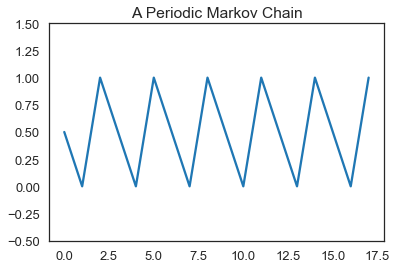

In [8]:
theta = [.5,0,1]*6
time = np.arange(3*6)
plt.plot(time,theta)
plt.title('A Periodic Markov Chain')
plt.ylim(-.5,1.5)
plt.show()

Remember, failing the aperiodicity assumption means that we **cannot use** our markov chain for any statistical inference, since we aren't guaranteed that it is capturing the true underlying posterior.

#### Irreducibility

A Markov Chain is irreducible if it is possible to go from any state to any other state (doesn't have to be in 1 step). 

This chain is reducible, since once we transition away from $\theta=0.5$, we never go back:
![](../site_pics/irreducible.png)

The problem is again, if our chain is reducible, we can't rely on the ergodic theorem to allow us to use our constructed chain for inference.  This one is much more difficult to visualize since something that looks reducible might re-occur if we persisted with a sufficiently long chain length.

#### Positive Recurrence

For positive recurrence, we need the time it takes for the chain to return to some value to be finite. 

Example. Suppose we are modeling the mean of a dataset as we have been doing.  A candidate value that is included in our chain is -10.  This value is very unlikely given our data:

In [9]:
norm(-10,sigma).pdf(data)

array([9.89591756e-14, 3.16951052e-08, 2.63872403e-13, ...,
       6.54483182e-13, 1.83032511e-13, 2.84562968e-12])

We do however, need for MH to have some positive probability of returning back to this value even if it is very small.  And MH does this because of the accept-reject criteria it employs- inferior values of our parameter vector are sometimes included.  So while it may take a very long time for the chain to return to -100 it will eventually (probably an extremely long time).

### Chain Pathologies

Ergodicity ensures that we explore the entire parameter space and never get "stuck" in any given place.  Sometimes however, we have a breakdown in the MCMC process where our chain is limited and can't fully explore $\theta$.  The following example shows a case where our chain is never allowed to go below -2.  It is easy to visualize the problem simply by examining the trace plot.

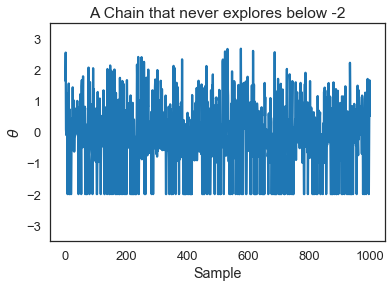

In [10]:
bad_chain = norm().rvs(1000)
bad_chain[bad_chain<-1] = -2

plt.plot(np.arange(1000),bad_chain)
plt.ylim(-3.5,3.5)
plt.xlabel('Sample')
plt.ylabel('$\\theta$')
plt.title('A Chain that never explores below -2');

Without getting too much in the weeds at this point, it may be possible to transform the parameter in the above case to sidestep the problem we can see above.

### Without ergodicity you are screwed

If we can't assume ergodicity, then we can't use our chain for inference.  You might be able to resort to practices like *thinning* to whinnow your chain down to something more like iid (and then rely on SLLN), but it will be difficult to convince your audience and it will require running very long chains.  

## MH MCMC Inference

Having established these three properties and having used random-walk MH, we are assured that our chain represents **somewhat** correlated random draws from the posterior that can be used for all manner of inference:

* Means
* Credible Intervals
* Medians
* Standard deviations

> Provided that our chain has converged to the limiting distribution, which is a numerical issue.